# MVPA MEG Tutorial (Matlab): RDMs and reliability

[Tutorial starting page](https://github.com/m-guggenmos/megmvpa/).

This tutorial accompanies the preprint titled "Multivariate pattern analysis for MEG: a comprehensive comparison of dissimilarity measures", which is available at [doi.org/10.1101/172619](https://doi.org/10.1101/172619).

**Goal of this tutorial:** compute representational dissimilarity matrices (RDMs) and the intersession-reliability for RDMs for the example of Support Vector Machine classification.

## Tutorial

We set a seed, in order to make analyses reproducible:

In [1]:
rng(10);

Let's load some data:

In [2]:
root = ''; % This is the /path/to the directory containing the data.
           % We leave it empty here, because the data is located in the current directory.

% Load data and trial labels for the two sessions of participant 01

% Session 1
load(fullfile(root, 'data01_sess1.mat'));
load(fullfile(root, 'labels01_sess1.mat'));
sessions(1).data = data01_sess1;
sessions(1).labels = labels01_sess1;
% Session 2
load(fullfile(root, 'data01_sess2.mat'));
load(fullfile(root, 'labels01_sess2.mat'));
sessions(2).data = data01_sess2;
sessions(2).labels = labels01_sess2;

Now we set some parameters. Only the number of permutations and the number of pseudo-trials are free parameters. The number of conditions, sensors, time points and sessions are derived from the data (i.e., from the `sessions` variable above).

In [3]:
% Parameters
n_perm = 20;  % number of permutations
n_pseudo = 5;  % number of pseudo-trials
n_conditions = length(unique(sessions(1).labels));
n_sensors = size(sessions(1).data, 2);
n_time = size(sessions(1).data, 3);
n_sessions = length(sessions);

The analytic logic is contained in a nested for loop, with loops for the number of sessions, number of permutations, number of timepoints, number of conditions, and number of conditions again. Overall, the logic contains 5 crucial steps:
1. Compute pseudo-trials for the training and test data
2. Whiten the training data (here using the Epoch method, which is recommended in our manuscript)
3. Fit the classifier to the training data
4. Predict samples from the test data
5. Compute the dissimilarity (here classification accuracy) for the current condition pair and store in RDM.

In [4]:
% pre-load mechanism, for convenience
preload_RDM = true;
if preload_RDM
    load(fullfile(root, 'result_reliability.mat'))
else
    RDM = nan(n_sessions, n_perm, n_conditions, n_conditions, n_time);
    for s = 1:n_sessions

        fprintf('Session %g / %g\n', s, n_sessions)

        X = sessions(s).data;
        y = sessions(s).labels;
        
        conditions = unique(y);
        n_trials = histc(y, conditions);

        for f = 1:n_perm
            fprintf('\tPermutation %g / %g\n', f, n_perm)
            
            % precompute permutations
            ind_pseudo_train = nan(n_conditions, n_conditions, 2*(n_pseudo-1));
            ind_pseudo_test = nan(n_conditions, n_conditions, 2);
            labels_pseudo_train = nan(n_conditions, n_conditions, 2*(n_pseudo-1));
            labels_pseudo_test = nan(n_conditions, n_conditions, 2);
            for c1 = 1:n_conditions
                range_c1 = (c1-1)*(n_pseudo-1)+1:c1*(n_pseudo-1);
                for c2 = 1:n_conditions
                    range_c2 = (c2-1)*(n_pseudo-1)+1:c2*(n_pseudo-1);
                    ind_pseudo_train(c1, c2, 1:2*(n_pseudo - 1)) = [range_c1 range_c2];
                    ind_pseudo_test(c1, c2, :) = [c1 c2];
                    labels_pseudo_train(c1, c2, 1:2*(n_pseudo - 1)) = ...
                        [conditions(c1)*ones(1, n_pseudo - 1) conditions(c2)*ones(1, n_pseudo - 1)];
                    labels_pseudo_test(c1, c2, :) = conditions([c1 c2]);
                end
            end              
            train_indices = cell(1, n_conditions*(n_pseudo-1));
            test_indices = cell(1, n_conditions);
            for c1 = 1:n_conditions  % separate permutation for each class
                prm_ = randperm(n_trials(c1));                
                prm = cell(1, n_pseudo);
                splitsize = n_trials(c1) / n_pseudo;
                for i = 1:n_pseudo
                    idxs = floor(round((i-1)*splitsize)):floor(round((i)*splitsize))-1;
                    prm{i} = prm_(idxs + 1);
                end                                
                ind = cellfun(@(x)x+sum(n_trials(1:c1-1)), prm, 'UniformOutput', 0);
                xrange = (c1-1)*(n_pseudo-1)+1:c1*(n_pseudo-1);
                for i = 1:length(xrange)
                    train_indices{xrange(i)} = ind{i};
                end
                test_indices{c1} = ind{end};
            end                                

            % 1. Compute pseudo-trials for training and test
            Xpseudo_train = nan(length(train_indices), n_sensors, n_time);
            Xpseudo_test = nan(length(test_indices), n_sensors, n_time);
            for i = 1:length(train_indices)
                Xpseudo_train(i, :, :) = mean(X(train_indices{i}, :, :), 1);
            end
            for i = 1:length(test_indices)
                Xpseudo_test(i, :, :) = mean(X(test_indices{i}, :, :), 1);
            end


            % 2. Whitening using the Epoch method
            sigma_conditions = reshape(squeeze(labels_pseudo_train(1, :, n_pseudo:end))', 1, []);
            sigma_ = nan(n_conditions, n_sensors, n_sensors);
            for c = 1:n_conditions
                % compute sigma for each time point, then average across time
                tmp_ = nan(n_time, n_sensors, n_sensors);
                for t = 1:n_time
                    tmp_(t, :, :) = covCor(Xpseudo_train(sigma_conditions==c, :, t));
                end
                sigma_(c, :, :) = mean(tmp_, 1);
            end
            sigma = squeeze(mean(sigma_, 1));  % average across conditions
            sigma_inv = sigma^-0.5;
            for t = 1:n_time
                Xpseudo_train(:, :, t) = squeeze(Xpseudo_train(:, :, t)) * sigma_inv;
                Xpseudo_test(:, :, t) = squeeze(Xpseudo_test(:, :, t)) * sigma_inv;
            end

            for t = 1:n_time
                for c1 = 1:n_conditions-1
                    for c2 = c1+1:n_conditions                        
                        % 3. Fit the classifier using training data
                        data_train = Xpseudo_train(ind_pseudo_train(c1, c2, :), :, t);
                        y_train = squeeze(labels_pseudo_train(c1, c2, :));
                        model_svm = svmtrain(y_train, data_train, '-c 1 -q 0 -t 0');

                        % 4. Compute predictions using test data
                        data_test = Xpseudo_test(ind_pseudo_test(c1, c2, :), :, t);
                        y_train = squeeze(labels_pseudo_test(c1, c2, :));
                        predictions = svmpredict(y_train, data_test, model_svm, '-q 0 -t 0');

                        % 5. Compute dissimilarity and store in RDM
                        dissimilarity = mean(predictions == y_train) - 0.5;
                        RDM(s, f, c1, c2, t) = mean(dissimilarity);
                    end
                end
            end
        end
    end
    % average across permutations
    RDM = squeeze(nanmean(RDM, 2));
    save(fullfile(root, 'result_reliability.mat'), 'RDM')
end

After computing the RDMs for each session and each timepoint, let's take a look at the data.

Let's take a look at the structure of `RDM`:

In [5]:
size(RDM)


ans =

     2     9     9   111



The variable `RDM` contains a #conditions x #conditions = 9x9 RDM for 2 sessions and 111 time points (note that the time resolution is 10 ms).

Now we compute two the session-to-session reliability of RDMs in two ways: pattern reliability and sum-of-squares[SSQ] reliability

In [6]:
reliability_pattern = nan(1, n_time);
reliability_ssq = nan(1, n_time);
for t = 1:n_time
    d1_ = squeeze(RDM(1, :, :, t));
    d1 = d1_(~isnan(d1_));
    d2_ = squeeze(RDM(2, :, :, t));
    d2 = d2_(~isnan(d2_));
    reliability_pattern(t) = corr(d1, d2);
    reliability_ssq(t) = 1 - sqrt(sum((d1-d2).^2))/sqrt(sum(d1.^2+d2.^2));
end

And plot across time:

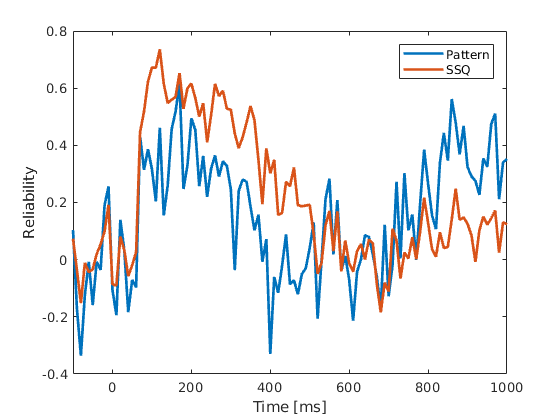

In [7]:
figure;
hold on
plot(-100:10:1001, reliability_pattern, 'linewidth', 2)
plot(-100:10:1001, reliability_ssq, 'linewidth', 2)
xlim([-100 1000])
xlabel('Time [ms]')
ylabel('Reliability')
legend('Pattern', 'SSQ')
box on

We see, that the reliability is generally more noisy compared to classification accuracy, since it is based on only two samples: session1 and session2. In addition, we can anticipate that SSQ reliability will be higher than pattern reliability for classification. In fact, the low pattern reliability is a specific problem of classification and is due to the loss of information, when computing the binary correctness of predictions.